# Finesse Tutorial: Investigating the 'DC offset'
Yashwant Bothra, Alina Soflau, Enzo Tapia, Andreas Freise

Nikhef

This notebook was used in the IMPRS School "Gravity at the Extreme: from Theory to Observation."

Date: 14th October 2025

# Sensitivity of advanced gravitational-wave (GW) detectors

In this notebook we will work with plots that are similar to the famous sensitivity plots you will often see. For this we will use roughly similar noises as the current detectors such as Advanced LIGO and Advanced Virgo. Our results will not be exactly the same as the official plots, however this should give you an appreciation of the steps involved in how to compute the sensitivity.

**After this notebook you will be able to**:

* model in Finesse
* compute the response of a GW detector to gravitational-wave signals
* compute the laser frequency & quantum noise 
* Understand DC-offsets in GW detectors
* read and explain a sensitivity curve

**This notebook assumes you know:**
* What a transfer function is
* What a signal-to-noise ratio means
* What amplitude and power spectral densities are
* How to run and create Finesse 3 models

# Some basic concepts

Before we jump into modeling GW detectors using Finesse, it would be helpful to explain a few concepts beforehand. These concepts will guide you through the notebook and help you appreciate the results you see in Finesse. We will only explain them briefly and provide references for those who wish to study them in more detail.

## Degrees of Freedom (Dofs)

In a Dual-Recycled Fabry–Perot Michelson Interferometer (DRFPMI), there are many degrees of freedom (DoFs) — both longitudinal and angular — that must be actively controlled to keep the interferometer at its desired operating point. In other words, the interferometer is continuously controlled so that it maintains maximum sensitivity within its targeted frequency bandwidth. The five longitudinal degrees of freedom in a DRFPMI are:

1. CARM – Common Arm Length
2. DARM – Differential Arm Length
3. PRCL – Power Recycling Cavity Length
4. SRCL – Signal Recycling Cavity Length
5. MICH – Michelson Degree of Freedom

Each of these DoFs corresponds to a specific physical length or optical path in the interferometer that affects how light resonates and interferes within the system. **For this tutorial, we will focus exclusively on the DARM DoF.** DARM is directly sensitive to GWs: a passing GW causes differential changes in the lengths of the two arm cavities, making DARM the primary channel for the astrophysical signal. The reason for focusing on DARM, and not the other longitudinal DoFs, will be explained below. 

## Noise sources in GW detectors

In all GW detectors there are many noise sources that are inherently present (detector self-noise). A large part of research in GW instrumentation is aimed at characterising and reducing these sources of noise. The various types of noise present in GW detectors include:

1. Quantum noise
2. Newtonian noise
3. Thermal noise
4. Seismic noise
5. Readout noise
6. Sensing and control noise

and many others. Some of these are fundamental in nature and intrinsic to interferometric measurements of GWs, whereas others can be described as technical noises arising from the way the detector is designed, and operated. 

**In this notebook/tutorial, we will focus primarily on quantum noise and laser frequency noise as examples. Our main goal is to understand how these noise sources shape the detector’s sensitivity to gravitational waves.**

Rather than focusing on the absolute level of laser frequency noise, we will study how different noise sources behave when expressed in terms of GW strain h. This allows us to compare their (different noise sources) relative impact on the detector’s ability to measure GWs. To do this, we will look at sensitivity plots, which show how sensitive a detector is to GWs of different frequencies. These plots are typically expressed in terms of strain sensitivity $\frac{h}{\sqrt{Hz}}$, where a lower value indicates better sensitivity (i.e., the ability to detect weaker signals).

**Finally, our goal is to study how these noise sources are affected by changing the so called "DC offset" of the interferometer. Towards the end of this tutorial, you as an experimentalist have to choose a DC offset for your model and justify your decision.**

## What is a DC offset? 

In current generation detectors we use a special case of 'homodyne' sensing scheme for detecting GW signals called the DC-offset. In this scheme we purposely tune the interferometer away from the dark fringe (no light) to have some light leaking through the dark port (anti-symmetric port) of the interferometer. This readout scheme has its pros and cons, but chosen to be our current detection technique. You can use this article to understand about various detection schemes a bit more in detail:

"DC-readout of a signal-recycled gravitational wave detector", Hild et al, CQG, 26, 5 (2009) https://arxiv.org/pdf/0811.3242 

For the purpose of this tutorial, we would like to understand how laser frequency and quantum noise couple to the output port of the interferometer for different values of the DC offset. By computing the total sensitivity of different noise sources you have to find the optimal DC offset for the best performance of the interferometer. 

## How do we create DC offset?

To create a DC offset, we use the DARM DoF by introducing a microscopic differential length change, commonly referred to as the DARM offset. The DARM DoF is defined as the differential arm length of the two long Fabry–Perot (FP) arm cavities:
$$
DARM = \frac{L_x - L_y}{2}
$$
where $L_x$ and $L_y$ are the lengths of the two arms.

In order to perform DC readout, we intentionally introduce a small length offset in DARM, denoted by $\Delta L_\epsilon$ (DARM offset). This offset is applied symmetrically: the length of one arm is increased by $\Delta L_\epsilon$ while the other is decreased by the same amount. 

This small microscopic offset alters the interference condition at the dark port (the output port). Ideally, without an offset, the interferometer is tuned such that all carrier light destructively interferes at the dark port, leaving it nearly dark. By introducing a DARM offset, we slightly de-tune the interferometer from this perfect destructive interference, allowing a small amount of carrier light to leak out at the dark port. This leaked light serves as the **local oscillator for the DC readout scheme**.

# Goals of this notebook

The majority of this notebook is dedicated to explaining various concepts and modeling techniques in Finesse. Go through them in order to understand how modeling is done in Finesse. These concepts are essential for you to complete the tasks and to interpret their results.

**To-do's:**

1. In this notebook, there are three tasks that you need to complete using Finesse. These tasks are related to the topic of DC offset.

2. Towards the end, you will give a short presentation (5–10 minutes) on your completed tasks. As you work through the tasks and question sets, it would be helpful to populate your slides simultaneously.

In [1]:
# install pypi wheel only on google colab
!env | grep -q 'colab' && pip install finesse || echo 'Not on google colab, assuming finesse already installed'

Not on google colab, assuming finesse already installed


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import finesse
from finesse.analysis.actions import Xaxis
finesse.init_plotting()

## Dual recycled Fabry-Perot Michelson Interferometer (DRFPMI)

Here we provide the Finesse code for a simplified Advanced GW detector roughly based on the Advanced LIGO parameters. As a first step you should look at the commands and nodes and **draw a sketch of the optical layout** to understand how the components are connected together. 

For documentation on Finesse (and various components being used) one can follow this link:
https://finesse.ifosim.org/docs/latest/usage/elements/index.html


In [3]:
## Finesse model of our interferometer
## ---------------------------------------------------------------------
## ---------------------------------------------------------------------

base = finesse.Model()
 
base.parse(""" 
# Input optics
l LI P=125 # l= laser
s s1 LI.p1 PRM.p1 L=0 #s= free space

# Power recycling mirror
m PRM T=0.03 L=37.5u phi=90 #m = mirror
s prc PRM.p2 bs1.p1 L=53

# Central beamsplitter
bs bs1 R=0.5 T=0.5 phi=0 alpha=45 #bs= beamsplitter

# X-arm
s sx bs1.p3 ITMX.p1 L=4.5
m ITMX T=0.014 L=37.5u phi=89.997
s Lx ITMX.p2 ETMX.p1 L=3995
m ETMX T=0 L=37.5u phi=89.997

# Y-arm
s sy bs1.p2 ITMY.p1 L=4.45
m ITMY T=0.014 L=37.5u phi=3m
s Ly ITMY.p2 ETMY.p1 L=3995
m ETMY T=0 L=37.5u phi=3m

# Signal recycling mirror
s src bs1.p4 SRM.p1 L=50.525
m SRM T=0.2 L=37.5u phi=-90

# These commands give the mirrors a mass
# by default they are infinitely heavy
free_mass ITMX_sus ITMX.mech mass=40
free_mass ETMX_sus ETMX.mech mass=40
free_mass ITMY_sus ITMY.mech mass=40
free_mass ETMY_sus ETMY.mech mass=40
           
# Detectors for readouts
pd1 TF SRM.p2.o f=fsig.f #detector to compute the transfer function at the dark port of the IFO.
""") 

### Modeling GW signal and computing the transfer function

GW signal causes a differential change in the two arms of the interferometer. Technically this can be thought of as a noise source which leads to the displacement of the test masses (mirrors). 

We now get to the stage we can model how a gravitational-wave signal would appear in our detector. The gravitational wave will modulate the phase of the light travelling along a space. We can apply this type of signal to a space component in Finesse 3 using: `sgen sig1 space.h`. 

The units of this transfer function are $W/h$ where $h$ is the gravitational wave strain. The strain value will typically be something very small, $h \sim 10^{-23}$.

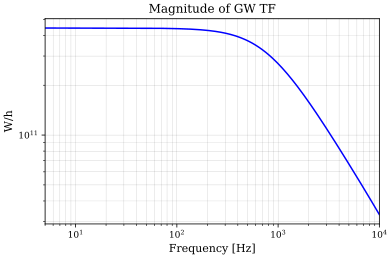

In [4]:
## Computes the gravitational wave signal TF at the dark port  
## -------------------------------------------------------------------------------------

# specifying our frequency range to be modelled 
fstart = 5 #Hz
fstop = 1e4
Npoints = 200

gw = base.deepcopy() #making a copy of our base model

# Its always advised to copy models and then make any changes to it. 
# This does not alter the base script and if something does not work, 
# you can always circle back.

# Here we add our new code to modulate the length of the arms simulating a GW
gw.parse(f"""
fsig(1)
       
sgen sig1 Ly.h 1 0
sgen sig2 Lx.h 1 180
""")

# computing a result by scanning the frequency range
out = gw.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
    
# We store the frequency and magnitude of the transfer function [W/h]
# (In general we need to store the magnitude and phase of the transfer 
# functions but we only need the magniture for these examples.)
f, Hs = out.x1, np.abs(out['TF'])

# Plotting
plt.loglog(f, Hs)
plt.ylabel("W/h")
plt.xlabel("Frequency [Hz]")
plt.title("Magnitude of GW TF")
plt.show()

## Question Set 1:

1. Try to interpret this TF. Does this transfer function tell you that the detector is more susceptible to low or high frequency gravitational waves?

2. The magnitude of the transfer function drops off as we go to higher frequencies, can you think why this is? 

### Effect of different laser power on the trasnfer function (TF) of a GW signal

Here, we present an example to illustrate how changing different parameters of our model affects the response or the magnitude of the transfer function (TF) of the gravitational-wave signal. As a demonstration, we vary the laser power of our previously defined 'gw' model. This example shows how one can quickly modify model parameters and use loops to compute the transfer function for different model configurations.

Similarly, other realistic parameters of the model can be changed in the same way. Each time a parameter is modified, the transfer function is recomputed, allowing us to study how the detector’s response evolves under different operating conditions.

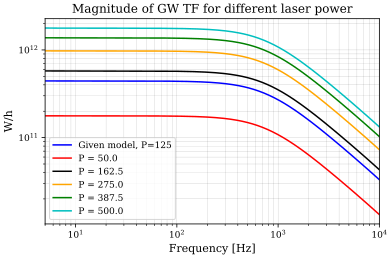

In [5]:
# Scanning over different input laser power and computing the GW signal TF
pw = np.linspace(50, 500, 5)  
tfs = np.empty([len(pw), len(f)]) #empty numpy array

for idx, p in enumerate(pw):
    gw.LI.P = p #changing the laser power in the model
    # computing the TF for a particular state of the IFO
    out = gw.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints)) 
    tfs[idx] = np.abs(out['TF'])

# Plotting all the TFs (magnitude) for different lser power
plt.loglog(f, Hs, label='Given model, P=125')
for idx, p in enumerate(pw):
    plt.loglog(f, tfs[idx], label=f"P = {p:.1f}")
plt.ylabel("W/h")
plt.xlabel("Frequency [Hz]")
plt.title("Magnitude of GW TF for different laser power")
plt.legend()
plt.show()

### Quantum noise limited sensitivity (QNLS)

"Quantum noise" is an umbrella term used to refer to multiple complicated effects in the interferometer. However, they are all a direct consequence of the photonic nature of the light field, their associated Poissonian statistics, and the Heisenberg uncertainty principle. The details are unimportant for our modeling tasks, but the interested reader may find this [review article](https://arxiv.org/abs/1203.1706) informative.

In Finesse 3 the `qnoised` detector can be used to directly compute the quantum noise amplitude spectral density at the output port of an interferometer.

The output of `qn` has the form $N_q(f) |H_p(f)|$, where $N_q$ is the amplitude spectral density of the quantum noise and $H_p$ the transfer function from quantum noise to the output port, so we can then directly combine this output with the GW transfer function computed earlier to get the *Quantum Noise Limited Sensitivity* of the interferometer:
$$S_q(f) = \frac{\mathtt{out[`qn`]}}{|H_s(f)|}$$

Here we compute the QNLS curve of our model. 

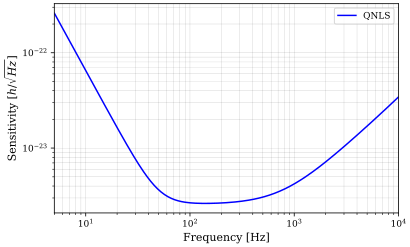

In [6]:
# Qunatum noise limited sensitivity (QNLS)
## --------------------------------------------------------

qls = base.deepcopy() #making a copy of the base model

qls.parse(f"""
fsig(1)
# compute the quantum-noise in the detector output
qnoised qn SRM.p2.o 
""")

# SRM.p2.o is the output port or dark-port of our interferometer (Singal Recycling Mirror, port 2, output). 
# We can use this point in the model as the 'dark port' of the interferometer, which
# is where we place the photo diode to detect the GW signal.

out = qls.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

# By dividing the noise with the transfer function for the signal we 
# can plot the quantum noise in the units of the GW, or 'equivalent strain'.
S_q_base = out['qn'] / Hs #QNLS of the IFO

# Plot
plt.loglog(f, S_q_base, label="QNLS")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Sensitivity [$h/\\sqrt{Hz}$]")
plt.legend()
plt.tight_layout()
plt.show()

From the above plot we see a bucket like shape, at high frequencies we are limited by **shot noise**.
At low frequencies we are dominated by **radiation pressure noise**. Shot noise is typically improved by increasing power. However, increased power means more radiation pressure noise. One can see how this behaves by replotting the above using different input laser powers.

### Laser frequency noise (limited sensitivity)

Above, we computed the QNLS of our model. Here, our goal is to study the laser frequency noise–limited sensitivity. To compute the strain-equivalent sensitivity limited by laser frequency noise, we use the following expression:

$$S_l(f) = \frac{N_l(f) |H_l(f)|}{|H_s(f)|}$$

where $S_l(f)$ is the __equivalent strain amplitude spectral density due to laser frequency noise__, $N_l(f)$ is the laser frequency noise ASD, $H_l(f)$ is the transfer function from the laser (or source of noise) to the output detector, and $H_s(f)$ is the transfer function of the gravitational wave signal. This quantity tells us how much a particular noise source, in this case laser frequency noise — mimics a GW signal at the output. In other words, it determines how laser frequency noise limits the detector’s strain sensitivity. As discussed earlier in the conceptual section, the unit of $S_l(f)$ is:

$$\frac{[Hz/\sqrt{Hz}] [W/Hz]}{[W/h]} = \frac{h}{\sqrt{Hz}}$$

which are the standard units of strain sensitivity, expressed as an __equivalent strain amplitude spectral density due to laser frequency noise__.

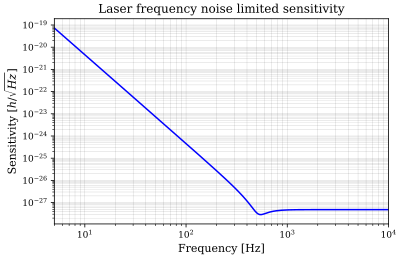

In [7]:
# Defining a laser frequency noise spectrum, this assumes a laser which has 
# already been frequecny stabilised significantly
def frequency_noise_ASD(f): 
    f = np.array(f)
    return 1e-2 / abs(np.random.normal(f, 0, size=f.size))

N_l = frequency_noise_ASD(f) 
# this remains the same for all ASD we will compute in this tutorial

fnoise = base.deepcopy()

# New code to add laser frequency noise
fnoise.parse(f"""
    fsig(1)
    sgen sig1 LI.frq 1 0 
    """ 
)

# Compute the transfer function for laser frquency changes
out = fnoise.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))
Hl_base = np.abs(out['TF']) 

## One can also plot the trasnfer function of the laser frequecny noise. 
## Here we skip that and plot the laser frequency noise limited sensitivity.

Sl_base = N_l*Hl_base/Hs #computing ASD in units strain

# laser frequency sensitivity plot
plt.loglog(f,Sl_base)
plt.xlabel("Frequency [Hz]")
plt.title("Laser frequency noise limited sensitivity")
plt.ylabel("Sensitivity [$h/\\sqrt{Hz}$]")
plt.show()

Now that you know how to add noise and study the noise-limited sensitivity, for the remainder of this tutorial we will focus on these two noise sources — quantum noise and laser frequency noise — for different values of DC offset. 

But before we begin studying DC offsets, it is useful to have a brief introduction to linking variables in Finesse. Later in this tutorial, we will use this feature to link the microscopic length tunings (**phi** in Finesse) of different mirrors to create the so called DARM offset. A short introduction here will help you understand how and why we set up these links.

## Linking variables in Finesse

In [8]:
## Current attributes/values in our model (example)

print("Current microscopic tuning (Phi) of End-mirror X :", base.ETMX.phi)
print("Current microscopic tuning of End-mirror Y :", base.ETMY.phi)

## Now lets say you want to link the phi of one mirror to the other.
## This will help in creating DARM offsets easily by just changing 
## the phi of one mirror. By linking the attributes, we create a dependency 
## between the two. We do this as shown below.

# linking EMTX phi to ETMY phi
base.ETMX.phi = 90.0 - base.ETMY.phi.ref 

# by doing this, we create a symbolic reference of microscopic length tuning  
# of end mirror (X) dependent of the tuning of end mirror (Y). 
# It gives a “handle” or "pointer" to the parameter itself.

print("Microscopic tuning after linking the attributes (X) : ", base.ETMX.phi)
# From the prints we can see that now the end mirror X is dependent on the end mirror Y.

## To check the actual value one can print
print("Value of microscopic tuning after linking:", base.ETMX.phi.eval()) # now the value has changed from the original by 0.003 deg.

Current microscopic tuning (Phi) of End-mirror X : 89.997 degrees
Current microscopic tuning of End-mirror Y : 0.003 degrees
Microscopic tuning after linking the attributes (X) :  (90.0-ETMY.phi) degrees
Value of microscopic tuning after linking: 89.997


## Response of the IFO for different DC offsets

To begin with, for simplicity, we tune the interferometer to complete dark fringe such that no light is leaking through and study the nature of the responses. 

Some helper functions would be provided for you to quickly compute transfer functions. Feel free to use them wherever necessary!

In [9]:
## Helper functions

# Computes the GW TF 
def compute_gwTF(model):
    gwsignal = model.deepcopy()

    # Add signal generators to simulate GW modulation in both arms
    gwsignal.parse(f"""
    fsig(1)
    sgen sig1 Ly.h 1 0
    sgen sig2 Lx.h 1 180
    """)

    # Run frequency sweep
    out = gwsignal.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

    # Extract frequency and magnitude of transfer function
    f_func = out.x1
    Hs_func = np.abs(out['TF'])

    return f_func, Hs_func

# Computes the TF for a single input node. For laser frequency use 
# input_node as "LI.frq" where LI is name of the laser and frq is 
# what we add noise to.

def get_TF(model, input_node):
    tf = model.deepcopy()
    tf.parse(f"""
    fsig(1)
    sgen sig1 {input_node} 1 0
    """)
    return tf.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

# Computes the QNLS. It does not return a value but a solution tree.
# To extract values please refer to previous computations of TF.

def QNLS(model):
    qls_func = model.deepcopy()

    qls_func.parse(f"""
    fsig(1)
    # compute the quantum-noise in the detector output
    qnoised qn SRM.p2.o 
    """)

    return qls_func.run(Xaxis('fsig.f', 'log', fstart, fstop, Npoints))

In [10]:
# Bringing the IFO to complete dark fringe 
dc = base.deepcopy()

# adding other complementary detectors for debugging.
dc.parse(
    """
    pd pd1 SRM.p2.o #other complementary detectors at different nodes
    pd pdr PRM.p1.o
    pd b7 ETMY.p1.o
    pd b8 ETMX.p1.o   
    pd bspd bs1.p4.o
    """
)

P_dc = dc.run()
print(f"DC power before tuning = {P_dc['pd1']:.3}")

# Changes (to bring to complete dark fringe)
## Here I intentionally by tuning the microscopic length (phi)
## of our mirrors, we bring it to the complete dark-fringe.
dc.ITMX.phi = 90
dc.ETMX.phi = 90
dc.ITMY.phi = 0
dc.ETMY.phi = 0

P_dc = dc.run()
print(f"DC power (dark-fringe) after tuning = {P_dc['pd1']:.3}")

# Linking the microscopic lengths (phi) of the two end mirrors for creating
# systematic DC offsets. 

dc.ETMX.phi = 90.0 - dc.ETMY.phi.ref
print("After linking ariables = ", dc.ETMX.phi)

DC power before tuning = 3.46e-06
DC power (dark-fringe) after tuning = 1.18e-30
After linking ariables =  (90.0-ETMY.phi) degrees


##### Now we use this model 'dc' for the rest of this tutorial. Please make sure to use this model for any analysis you do.

Power at dark port = 1.18e-30
Power at dark port = 3.1e-10
Power at dark port = 0.031
Power at dark port = 3.03
Power at dark port = 73.4
Power at dark port = 2.73


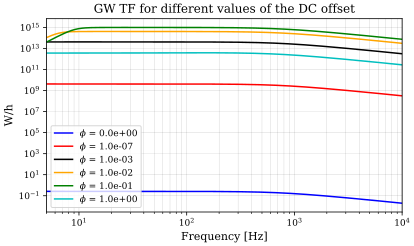

In [11]:
## Studying responses for different DC offsets
## We create different DC offsets by changing the microscopic length tunings 
## of the arms (DARM offset), which was explained earlier. 

tfunc = dc.deepcopy() #making a copy of the model

phis = [0, 1e-7, 1e-3, 1e-2, 1e-1, 1e0] #different phi tunings
h_gw = []

for idx, p in enumerate(phis):
    # Applying the DC offset as differential tuning of the end mirrors
    tfunc.ETMY.phi = p #due to the linking of parameters this also simultaneously modifies the tuning of end mirror in X
    P_dc = tfunc.run()
    print(f"Power at dark port = {P_dc['pd1']:.3}")

    # TF of the GW signal for different tunings
    ffunc, hsfunc = compute_gwTF(tfunc)
    h_gw.append(hsfunc)

# Plot quantum noise limited sensitivities
for idx, p in enumerate(phis):
    plt.loglog(f, h_gw[idx], label=f"$\\phi$ = {p:.1e}")
plt.xlabel("Frequency [Hz]")
plt.ylabel('W/h')
plt.title("GW TF for different values of the DC offset")
plt.legend()
plt.tight_layout()
plt.show()

# Task 1

For the above given DC offsets (different DC power at the dark port), plot the corresponding laser frequency and quantum noise limited sensitivity for each of the different phi tunings. 

In [12]:
## Your script for task 1
sl_dc = []
s_q = []

for idx, p in enumerate(phis):
    tfunc.ETMY.phi = p
    P_dc = tfunc.run()
    print(f"Power at output port = {P_dc['bspd']:.3}")

    # Laser frequency limited sensitivity

    """Add your code here"""

    # QNLS

    """Add your code here"""


## Plot QNLS

"""Add your code here"""

## Plot laser frequency limited sensitivity

"""Add your code here"""

Power at output port = 5.92e-30
Power at output port = 1.55e-09
Power at output port = 0.155
Power at output port = 15.2
Power at output port = 3.67e+02
Power at output port = 13.7


'Add your code here'

## Question Set 2:

1. We can change the DC offset by tuning the length of one of the arms. Why do you think we introduce equal and opposite offset? **Hint: Think of other dofs in our interferometer. If we make tunings only in one arm, what happens to the CARM dof? The CARM dof is defined as $\frac{L_x + L_y}{2}. $**

# Task 2: DC offset v/s Detector Response

Choosing the right DC offset requires some preliminary study and an understanding of how the detector’s response (transfer function and sensitivity) changes for different noise sources. For this task, plot the following:

1. Magnitude of the GW transfer function at 100 Hz (W/h) vs. the microscopic length tuning of the end mirror (ETMY).
Please note that we have already linked the microscopic tuning parameters of the end mirrors in the two arms.

2. Magnitude of the laser frequency noise transfer function at 100 Hz (W/h) vs. the microscopic length tuning of the end mirror (ETMY).

The end-mirror tunings correspond to different DC offsets. What you are actually examining is the detector response as a function of different DC offset.

These plots will show how the response for different noise sources changes with DC offset. Study them carefully and interpret what the trends imply for choosing a suitable operating point.

In [13]:
# Magnitude of laser frequency noise v/s different DC offsets
dcoffset = dc.deepcopy() #copying the dc model

# fsig(100) is equivalent to studying the response at 100 Hz
# Adding code to study laser frequency noise

"""Add your code here"""

# Computing TF for laser noise
out1 = dcoffset.run(Xaxis('ETMY.phi', 'lin', 0, 0.3, 2000)) #its similar to using loops to change phi

"""Add your code here"""

# Plots

"""Add your code here"""

'Add your code here'

In [14]:
## Magnitude of GW TF v/s different DC offsets
dcoffset = dc.deepcopy() #copying the dc model

## Add your GW signals to your model

"""Add your code here"""

# Computing TF for GW

"""Add your code here"""

# Plots

"""Add your code here"""

'Add your code here'

## Question Set 3: 

1. Why is there a maximum magnitude for GW TF v/s DC offsets? More power means more signal so the response should scale linearly. Why do we see a peak and then a drop-off? 
2. Just by looking at these plots, what DARM offset (or length tuning) would you choose for your model? Please justify your answer. 
3. Is it true that one should always choose maximum DC offset for better Signal to Noise ratio? If not what other considerations does one have to take into account?

# Task 3: Choose the Optimal DC offset

You're an experimentalist and given the task to choose DC offset for your model. The few criterias you have to keep in mind are:
1. Signal-to-noise (SNR) ratio 
2. Laser frequency limited sensitivity and 
3. Qunatum noise limited sensitivty

For this task, plot the laser frequency and quantum noise limited sensitivity at 100 Hz for the same phi tunings as Task 2. Please remember that you have already computed the TF at 100 Hz. Now you only have to compute the sensitivity curves. 

After plotting these, choose the optimal phi tunings for your model to have an optimal DC offset. 

In [15]:
## Laser noise limited sensitivity at f=100Hz

"""Enter your code here"""

## Quantum noise limited sensitivity at f=100Hz

"""Enter your code here"""

## Plot

"""Enter your code here"""

'Enter your code here'